In [13]:
import os
import datetime

import IPython
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler, StandardScaler


mpl.rcParams['figure.figsize'] = (15, 5)
mpl.rcParams['axes.grid'] = False
plt.style.use('ggplot')

In [14]:
# creating a dataframe from the csv file
df = pd.DataFrame(pd.read_csv('../output/zero4_outputs.csv'))
df = df.drop([df.columns[0]], axis='columns') 
df = df.iloc[:,:-3]
df.reset_index(drop=True, inplace=True)
  
# Change UTC Time to CST Time 
from datetime import datetime

CST_time_list = []
for time in df['Time'].to_list():
    CST_time_list.append(datetime.fromtimestamp(time))

df['Time'] = pd.DataFrame(CST_time_list)

# Date Time: Minutes Seconds
# df.index = pd.to_datetime(df['Time'], format='%d.%m.%Y %H:%M:%S')
date_time = df['Time'].dt.strftime('%M %S')

# checking our dataframe once again
df.head()

,Time,Subcar_0,Subcar_1,Subcar_2,Subcar_3,Subcar_4,Subcar_5,Subcar_6,Subcar_7,Subcar_8,...,Subcar_52,Subcar_53,Subcar_54,Subcar_55,Subcar_56,Subcar_57,Subcar_58,Subcar_59,Subcar_60,Subcar_61
0,2022-01-08 08:35:41.784772,5499.938181,7461.867126,6230.129694,8741.921642,297.127919,327.200244,362.527240,353.411941,351.432782,...,437.649403,412.093436,393.782935,396.807258,398.600050,399.450873,405.544079,402.951610,372.625818,343.914233
1,2022-01-08 08:35:42.807257,5499.938181,7461.867126,6230.129694,8741.921642,350.910245,340.565706,338.013313,332.434956,327.232333,...,367.766230,339.484904,339.087009,343.083080,343.739727,346.943799,351.039884,350.000000,353.509547,361.763735
2,2022-01-08 08:35:43.831145,5499.938181,7461.867126,6230.129694,8741.921642,357.572370,389.307077,421.911128,424.001179,447.754397,...,466.309983,418.119600,397.935924,387.985824,371.260017,354.983098,338.710791,315.483756,278.195974,245.790561
3,2022-01-08 08:35:44.854967,5499.938181,7461.867126,6230.129694,8741.921642,507.385455,518.653063,533.348854,545.424605,542.492396,...,459.243944,413.706418,406.503383,392.998728,389.802514,381.072172,390.508643,384.002604,387.497097,393.782935
4,2022-01-08 08:35:45.880211,5499.938181,7461.867126,6230.129694,8741.921642,379.117396,397.553770,415.226444,450.480854,445.583887,...,653.314626,626.906692,633.941638,639.366092,651.254942,668.481862,671.060355,670.391677,646.208945,616.507096


In [15]:
df.shape

(3802, 62)

In [16]:
df.describe().transpose()[['mean', 'std']]

,mean,std
Subcar_0,5482.579092,308.541115
Subcar_1,7455.158794,114.541341
Subcar_2,6233.369403,63.095344
Subcar_3,8730.690589,167.604655
Subcar_4,437.319876,494.960094
...,...,...
Subcar_57,502.927628,138.522243
Subcar_58,504.431694,143.006393
Subcar_59,498.711610,146.211228
Subcar_60,484.847800,147.493317


<AxesSubplot:>

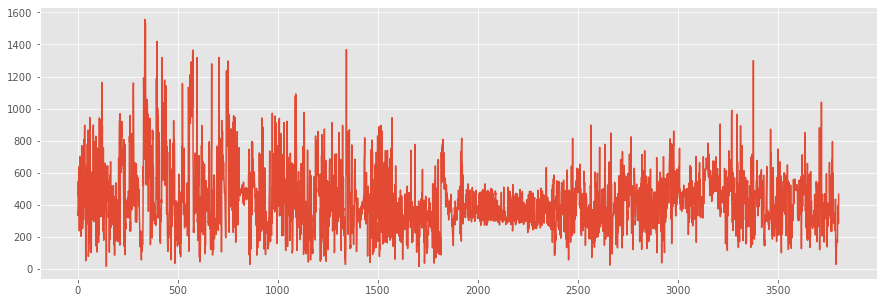

In [17]:
temp = df['Subcar_7']
temp.plot()

In [18]:
def df_to_X_y(df, window_size):
    df_as_np = df.to_numpy()
    X = []
    y = []
    for i in range(len(df_as_np) - window_size):
        row = [[a] for a in df_as_np[i:i + 5]]
        X.append(row)
        label = df_as_np[i+5]
        y.append(label)
    return np.array(X), np.array(y)

In [19]:
WINDOW_SIZE = 144
X, y = df_to_X_y(temp, WINDOW_SIZE)
X.shape, y.shape

((3658, 5, 1), (3658,))

In [20]:
x_train, y_train = X[:2000], y[:2000]
x_test, y_test = X[700:750], y[700:750]
x_val, y_val = X[750:], y[750:]
print('x_train set:', x_train.shape)
print('y_train set:', y_train.shape)
print('x_test set:', x_test.shape)
print('y_test:', y_test.shape)
print('x_val set:', x_val.shape)
print('y_val set:', y_val.shape)

x_train set: (2000, 5, 1)
y_train set: (2000,)
x_test set: (50, 5, 1)
y_test: (50,)
x_val set: (2908, 5, 1)
y_val set: (2908,)


In [21]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.metrics import MeanAbsoluteError
from tensorflow.keras.optimizers import Adam

In [22]:
model4 = Sequential()
model4.add(InputLayer((5, 1)))
model4.add(Conv1D(64, kernel_size=2))
model4.add(Conv1D(32, kernel_size=2))
model4.add(Flatten())
model4.add(Dense(8, 'relu'))
model4.add(Dense(1, 'linear'))

model4.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_2 (Conv1D)            (None, 4, 64)             192       
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 3, 32)             4128      
_________________________________________________________________
flatten_1 (Flatten)          (None, 96)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 8)                 776       
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 9         
Total params: 5,105
Trainable params: 5,105
Non-trainable params: 0
_________________________________________________________________


In [23]:
cp = ModelCheckpoint('../save/model4/', save_best_only=True)
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=2,
    mode='min'
)
model4.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.0001), metrics=[MeanAbsoluteError()])

In [24]:
model4.fit(x_train,y_train, validation_data=(x_val, y_val),  epochs=10, callbacks=[early_stopping,cp])

Epoch 1/10
63/63 [==============================] - 1s 10ms/step - loss: 136441.1719 - mean_absolute_error: 301.9102 - val_loss: 53311.0469 - val_mean_absolute_error: 188.9479
Epoch 2/10
63/63 [==============================] - 1s 9ms/step - loss: 59725.9688 - mean_absolute_error: 182.7012 - val_loss: 29473.1230 - val_mean_absolute_error: 126.5011
Epoch 3/10
63/63 [==============================] - 1s 9ms/step - loss: 48003.6367 - mean_absolute_error: 158.7970 - val_loss: 27068.3164 - val_mean_absolute_error: 119.2523
Epoch 4/10
63/63 [==============================] - 1s 11ms/step - loss: 46592.0156 - mean_absolute_error: 156.4426 - val_loss: 26529.1660 - val_mean_absolute_error: 117.8648
Epoch 5/10
63/63 [==============================] - 1s 9ms/step - loss: 45772.2969 - mean_absolute_error: 155.0584 - val_loss: 26076.3086 - val_mean_absolute_error: 116.7439
Epoch 6/10
63/63 [==============================] - 1s 9ms/step - loss: 45067.4922 - mean_absolute_error: 153.9550 - val_loss: 

In [25]:
from tensorflow.keras.models import load_model
model1 = load_model('../save/model4/')

In [26]:
test_predictions1 = model1.predict(x_test).flatten()
test_results1 = pd.DataFrame(data={'Test predictions': test_predictions1, 'Actuals': y_test})
test_results1

,Test predictions,Actuals
0,409.679993,1318.891959
1,638.205139,427.907700
2,669.013977,308.974109
3,584.528564,375.431751
4,489.520874,315.995253
5,446.578339,323.487249
6,324.707916,281.128085
7,298.617096,346.161812
8,304.013519,294.266886
9,295.335907,291.756748


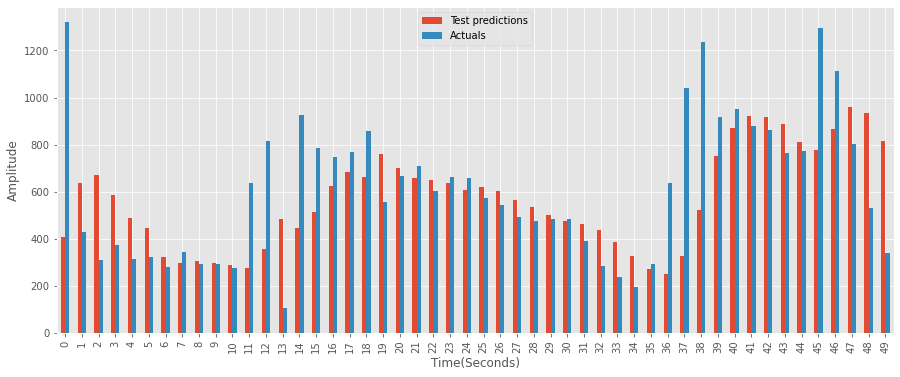

In [27]:
fig,ax = plt.subplots(figsize=(15,6))
test_results1.plot(kind='bar',ax=ax)
ax.set_xlabel("Time(Seconds)")
ax.set_ylabel("Amplitude")
plt.show()

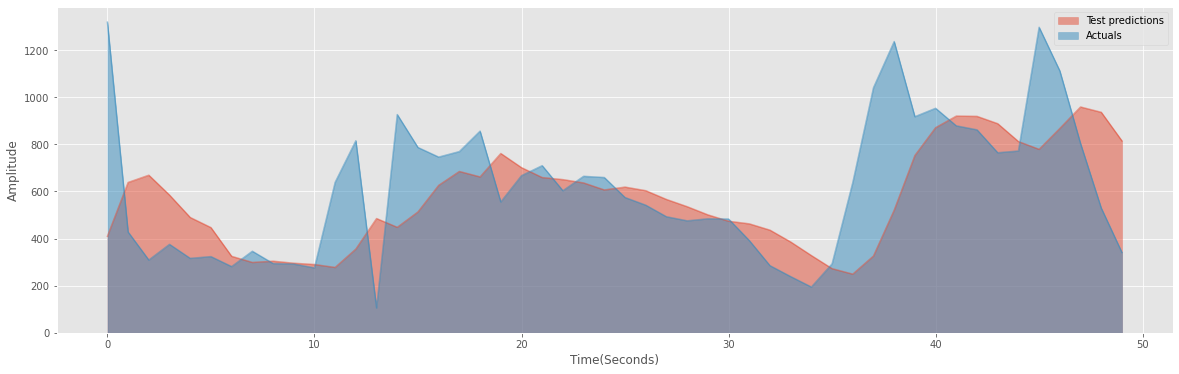

In [28]:
fig,ax = plt.subplots(figsize=(20,6))
test_results1.plot(kind='area',ax=ax,stacked=False)
ax.set_xlabel("Time(Seconds)")
ax.set_ylabel("Amplitude")
plt.show()

Text(0, 0.5, 'Amplitude')

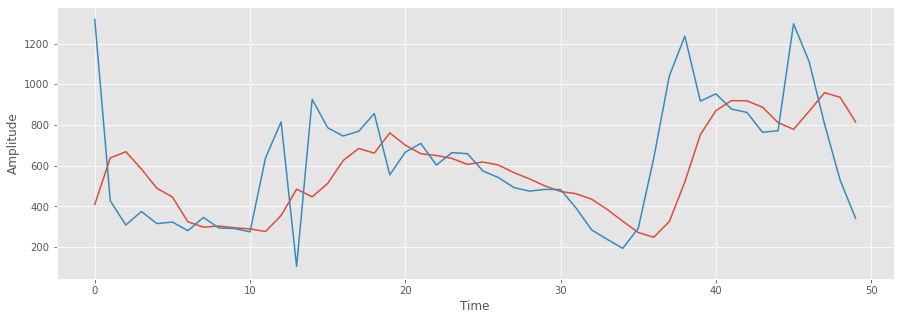

In [29]:
plt.plot(test_results1['Test predictions'])
plt.plot(test_results1['Actuals'])
plt.xlabel("Time")
plt.ylabel("Amplitude")

In [30]:
model5 = Sequential()
model5.add(InputLayer((5, 1)))
model5.add(Conv1D(64, kernel_size=2,))
model5.add(Conv1D(32, kernel_size=2, ))
model5.add(Flatten())
model5.add(Dense(8, 'relu'))
model5.add(Dense(1, 'linear'))

model5.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_4 (Conv1D)            (None, 4, 64)             192       
_________________________________________________________________
conv1d_5 (Conv1D)            (None, 3, 32)             4128      
_________________________________________________________________
flatten_2 (Flatten)          (None, 96)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 8)                 776       
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 9         
Total params: 5,105
Trainable params: 5,105
Non-trainable params: 0
_________________________________________________________________


In [31]:
cp3 = ModelCheckpoint('../save/model5/', save_best_only=True)
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=2,
    mode='min'
)
model5.compile( optimizer=Adam(learning_rate=0.0001), 
                loss=MeanSquaredError(), metrics=[MeanAbsoluteError()])

In [32]:
model5.fit(x_train, y_train, validation_data=(x_val, y_val), epochs=10, callbacks=[early_stopping, cp3])

Epoch 1/10
63/63 [==============================] - 1s 10ms/step - loss: 134014.0625 - mean_absolute_error: 295.3911 - val_loss: 40742.5703 - val_mean_absolute_error: 158.0415
Epoch 2/10
63/63 [==============================] - 1s 9ms/step - loss: 51392.4375 - mean_absolute_error: 165.6323 - val_loss: 27024.9492 - val_mean_absolute_error: 118.8865
Epoch 3/10
63/63 [==============================] - 1s 11ms/step - loss: 46212.3516 - mean_absolute_error: 155.9825 - val_loss: 26198.7148 - val_mean_absolute_error: 116.8317
Epoch 4/10
63/63 [==============================] - 1s 9ms/step - loss: 44881.2383 - mean_absolute_error: 153.4918 - val_loss: 25687.5000 - val_mean_absolute_error: 115.5436
Epoch 5/10
63/63 [==============================] - 1s 9ms/step - loss: 43636.2891 - mean_absolute_error: 150.9460 - val_loss: 24964.7070 - val_mean_absolute_error: 113.7569
Epoch 6/10
63/63 [==============================] - 1s 9ms/step - loss: 42669.5195 - mean_absolute_error: 149.5018 - val_loss: 

In [33]:
from tensorflow.keras.models import load_model
model5 = load_model('../save/model5/')

In [34]:
test_predictions2 = model5.predict(x_test).flatten()
test_results2 = pd.DataFrame(data={'Test predictions': test_predictions2, 'Actuals': y_test})
test_results2

,Test predictions,Actuals
0,457.057129,1318.891959
1,740.108459,427.907700
2,637.185242,308.974109
3,494.885742,375.431751
4,484.462036,315.995253
5,457.625793,323.487249
6,325.298737,281.128085
7,298.438263,346.161812
8,312.169434,294.266886
9,299.649811,291.756748


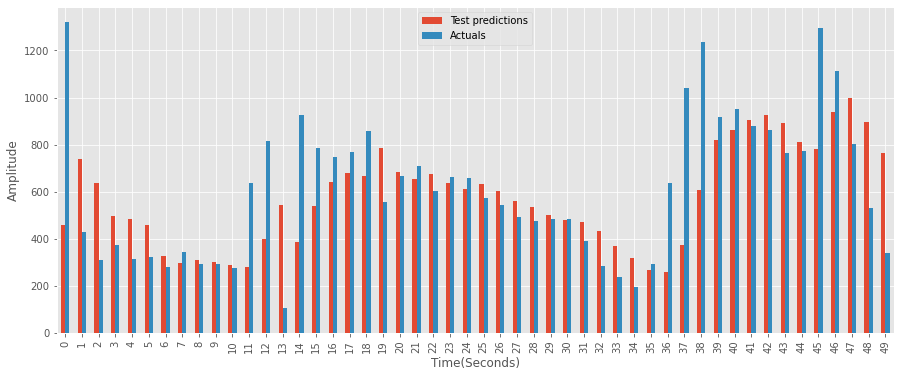

In [35]:
fig,ax = plt.subplots(figsize=(15,6))
test_results2.plot(kind='bar',ax=ax)
ax.set_xlabel("Time(Seconds)")
ax.set_ylabel("Amplitude")
plt.show()

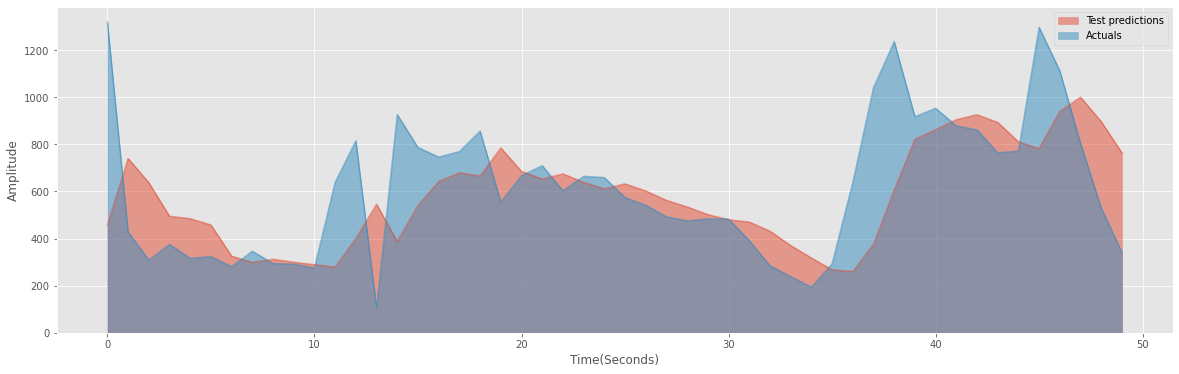

In [36]:
fig,ax = plt.subplots(figsize=(20,6))
test_results2.plot(kind='area',ax=ax,stacked=False)
ax.set_xlabel("Time(Seconds)")
ax.set_ylabel("Amplitude")
plt.show()

Text(0, 0.5, 'Amplitude')

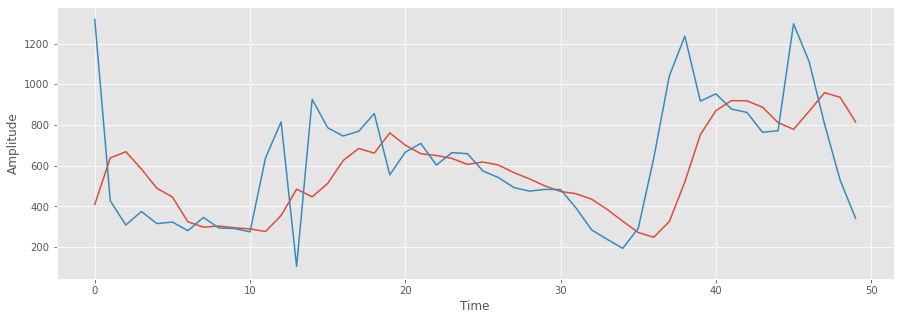

In [37]:
plt.plot(test_results1['Test predictions'])
plt.plot(test_results1['Actuals'])
plt.xlabel("Time")
plt.ylabel("Amplitude")

In [38]:
X = df.iloc[:, [7,10] ]
y = df.iloc[:, 9]

In [39]:
X.head()

,Subcar_6,Subcar_9
0,362.527240,353.793725
1,338.013313,319.820262
2,421.911128,441.279956
3,533.348854,562.694411
4,415.226444,458.423385


In [40]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [43]:
x_train1, x_test1, y_train1, y_test1 = train_test_split(X, y, test_size=0.2,random_state=100)

In [44]:
x_train1.head()

,Subcar_6,Subcar_9
2518,389.867926,363.323547
3093,483.467682,464.009698
3005,613.481866,605.324706
115,785.800229,753.050463
529,345.833775,330.024242


In [45]:
scaler = StandardScaler()
x_train1 = scaler.fit_transform(x_train1)

In [46]:
x_test1 = scaler.transform(x_test1)

In [47]:
scaler.mean_

array([424.24966958, 411.9004845 ])

In [48]:
# variance
scaler.scale_

array([202.35292646, 171.66761073])

In [49]:
x_train_scaled = scaler.transform(x_train1)

C:\Users\Owner\anaconda3\envs\Tensorflow210\lib\site-packages\sklearn\base.py:446: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  "X does not have valid feature names, but"


In [51]:
# mean of standardize data
x_train_scaled.mean(axis=0)

array([-2.09658282, -2.3994071 ])

In [50]:
# scaled variance/ std
x_train_scaled.std(axis=0)

array([0.00494186, 0.00582521])